# Topic 4: Logistic/Softmax Regression
## Associated Reading: Bishop 4.3 (Probabilistic Discriminative Models)

# 1 Refactoring the Bayes Classifier
For the purposes of classification, we have so far explored a class of model called the Bayes classifier.  This classifier worked by specifying the joint probability distribution of the class and the feature values:
$$P(\mathbf{x},y),$$
where $\mathbf{x}$ is a vector of features, and $y$ is a class label.

It was then easy to use Bayes' rule to infer the class:
$$
P(Y=y|\mathbf{X}=\mathbf{x}) \propto P(\mathbf{X}=\mathbf{x}|Y=y)P(Y=y).
$$

However, this required the specification of a statistical model for each class (what is the distribution of $\mathbf{X}$ given y).  Consider the lobster example for naive Bayes, in which we assumed that the features $\mathbf{X}$ were normally distributed (independent from one another), with some mean and covariance that depended on which class they were a member of. 
$$
P(\mathbf{x}|y) = \begin{cases} \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_0,\Sigma_0) & \mathrm{if}\;y=0, \\
                                \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_1,\Sigma_1) & \mathrm{if}\;y=1 \end{cases}
$$
where $\boldsymbol{\mu}_1$ and $\Sigma_1$ are the mean and diagonal covariance matrix of the *survived* class (and conversely for $\boldsymbol{\mu}_0$, etc.).  

Similarly we had a prior
$$
P(Y=y) = \theta^y (1-\theta)^{1-y}
$$
which is the probability of a lobster's survival without knowing its size.  We fit our model by finding the maximum likelihood estimators of the various $\mu$,$\sigma^2$, and $\theta$.  

This is all well and good, but sometimes it's not so easy to make an assumption about how the data are distributed!  For example, why should lobster size be normally distributed?  How do we even know?  This leads us to an alternative way to perform classification called *discriminative classification*, in which rather than model the features as an explicit statistical model, we'll come up with a function that takes as input the features, and outputs a probability for each class.  

What function should we use for such an endeavor?  Let's begin by looking at the two-class naive Bayes model again, where we are interested in the survival probability.  By definition, 
$$
P(Y=1|\mathbf{x}) = \frac{P(\mathbf{x}|Y=1)P(Y=1)}{P(\mathbf{x}|Y=1)P(Y=1) + P(\mathbf{x}|Y=0)P(Y=0)}.
$$
Note that the first term in the denominator is the same as the numerator.  Thus we could simplify this expression by writing:
$$
P(Y=1|\mathbf{x}) = \frac{1}{1 + \frac{P(\mathbf{x}|Y=0)P(Y=0)}{P(\mathbf{x}|Y=1)P(Y=1)}}.
$$
**What is the remaining term in the denominator called (specifically in the context of horse racing?**
<img src="images/horse_racing.jpg" style="width: 400px;">



If we make the identification
$$
a(\mathbf{x}) = \ln \frac{P(\mathbf{x}|Y=1)P(Y=1)}{P(\mathbf{x}|Y=0)P(Y=0)},
$$
we can simplify the expression further to just
$$
P(Y=1|\mathbf{x}) = \frac{1}{1 + \mathrm{e}^{-a}}.
$$
The quantity $a$ is called the log-odds.  This is a useful quantity because it squishes the odds down to a symmetric function on the complete real line.  The resulting function, parameterized in terms of $a$ ends up being common enough that it has a name: **the logistic function**:
$$
\sigma(a) = \frac{1}{1 + \mathrm{e}^{-a}}.
$$
The logistic function takes a number on the real line, and squashes it down to a value between zero and one, a proper probability.  (Note that you'll also sometimes hear this called a sigmoid, but sigmoid rightly refers to all functions that are vaguely s-shaped).  Here's what it looks like

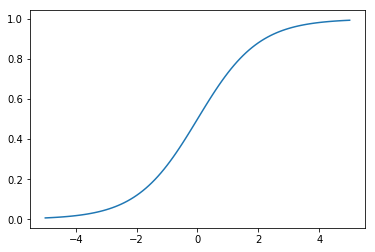

In [2]:
import numpy as np
import matplotlib.pyplot as plt
a = np.linspace(-5,5,101)

def sigmoid(a):
    return 1./(1+np.exp(-a))

plt.plot(a,sigmoid(a))
plt.show()

This gives us some insight into what naive Bayes is doing: we're taking the log-odds of the data for the two classes, and turning it into a class probability by running it through the logistic function.  

As it turns out, in this univariate case if we use the naive Bayes model, we can write down exactly what $a$ is as a quadratic function of the features (dropping the bold on $x$, since it's just a scalar):
$$
a(x) = w_2 x^2 + w_1 x + w_0 ,
$$
where 
$$
w_2 = \frac{1}{2}\left[\frac{1}{\sigma^2_0} - \frac{1}{\sigma^2_1}\right]
$$
$$
w_1 = \frac{\mu_1}{\sigma^2_1} - \frac{\mu_0}{\sigma^2_0}
$$
$$
w_0 = -\frac{1}{2}\frac{\mu_1^2}{\sigma_1^2} + \frac{1}{2}\frac{\mu_0^2}{\sigma_0^2} + \ln\frac{\pi_1}{\pi_0}.
$$
It's important to recognize that by using these definitions, we haven't done anything different from a normal Bayes classifier.  All we've done is rewrite Bayes' theorem in terms of $a$, and $a$ in terms of $w$.  In fact, I can get exactly the same result out of the lobster classifier by using these formulae.

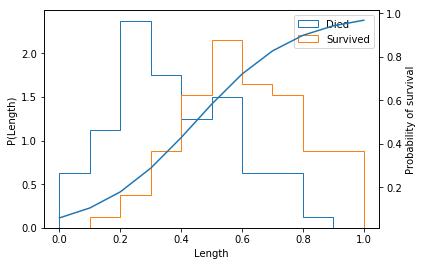

In [6]:
import numpy as np
data = np.loadtxt('datasets/lobster_survive.dat',skiprows=1)

import matplotlib.pyplot as plt
x = data[:,0]
x -= x.min()
x/=x.max()
y = data[:,1]

mu_0 = np.mean(x[y==0])
mu_1 = np.mean(x[y==1])
sigma_0 = np.std(x[y==0])**2
sigma_1 = np.std(x[y==1])**2
pi_1 = y.mean()
pi_0 = 1-pi_1

w_0 = -0.5*mu_1**2/sigma_1 + 0.5*mu_0**2/sigma_0 + np.log(pi_1/pi_0)
w_1 = mu_1/sigma_1 - mu_0/sigma_0
w_2 = 0.5*(1./sigma_0 - 1./sigma_1)

def logistic_function(a):
    return 1./(1+np.exp(-a))
    
a_logistic = w_0 + w_1*x + w_2*x**2
bins = np.unique(x)
plt.hist(x[y==0],bins,histtype='step',density=True,label='Died')
plt.hist(x[y==1],bins,histtype='step',density=True,label='Survived')
plt.legend()
plt.xlabel('Length')
plt.ylabel('P(Length)')
ax = plt.twinx()
ax.plot(x,logistic_function(a_logistic))
ax.set_ylabel('Probability of survival')
#plt.legend()
plt.show()

# 2 Logistic Regression

Notice that $\mathbf{w}$ is written in terms of values of $\mu$ and $\sigma$, which themselves are found via maximum likelihood estimation.  Thus, **it was by explicitly modelling the data and the class using the normal and Bernoulli distribution that we are able to write down these values of $\mathbf{w}$**.  

However, what if these values aren't actually the best choice for predicting the data.  There's no big law out there saying that naive Bayes using a normal distribution to model lobster length is the *most accurate classifier*.  Maybe a Gamma distribution would be better (after all, lobster length cannot be negative, yet the normal distribution allows for that).  Or maybe some other exotic thing.  **What if we don't even know what a reasonable distribution would be?**.  

When we explicitly set a distribution on the features, we (implicitly) asked the following question: **Given that my features are distributed according to my chosen distribution, what is $a(x)$?**.  An alternative strategy is to ask the question:  **What is the value of $a(x)$ that maximizes the predictive accuracy of the sigmoid?**  Note that this latter question does *not* involve putting a distribution on $\mathbf{x}$.  Instead, we'll just make a simple assumption about the form of $a(x)$.  

A common choice is to assume that $a(x)$ is a linear function of $x$:
$$
a(x,\mathbf{w}) = w_0 + w_1 x,
$$
with parameters $w_0$ and $w_1$ to be determined.  Of course, we can choose whatever we'd like for this model.  For example
$$
a(x,\mathbf{w}) = w_0 + w_1 x + \cdots + w_p x^p
$$
is an arbitrarily high order polynomial, but usually we'll want to keep it simple.  

Note that this is a very similar model to what we used in linear regression; however recall that this time the output gets sent through the logistic function.
$$
P(y|x) = \sigma(x,\mathbf{w}) = \frac{1}{1+\mathrm{e}^{-a(x,\mathbf{w})}}
$$
This similarity is where the name *logistic regression* comes from, even though we're not doing regression!  

**Now that we have a model specified, how shall we find the weights?**  

Just as we did with linear regression, we need to find a function to minimize.  In that content we used sum squared error to measure the difference between our predictions and observations.  However, squared error doesn't really make sense for binary data.  We need an alternative SSE-like thing that is appropriate for a binary classification problem.  How should we get such a thing?  

Let's continue with the probabilistic viewpoint, since the output of the sigmoid is a probability.  Recall that for the Bernoulli distribution, we had that 
$$
P(Y=y|\theta) = \theta^y (1-\theta)^{1-y}.
$$
In circumstances in which $Y=1$ most of the time, $\theta$ ended up large.  Conversely, when we expected $Y=0$ most of the time (after looking at the data), $\theta$ was small.  Our situation here isn't too dissimilar: we want $\theta$ to be close to 1 for cases where the model should predict $Y=1$, and $\theta$ should be close to zero where the model ought to predict $Y=0$ .  

The logistic function gives us a mechanism for doing just that.  It's a function that varies between zero and one and has parameters to tune in order to get different behaviors based on our inputs $x$.  Thus we can write 
$$
P(Y=y|x,\mathbf{w}) = \sigma(a)^y (1-\sigma(a))^{1-y}.
$$
If we make a bunch of observations of $x$ and $y$, we can cast this as a maximization problem:  Maximize with respect to $\mathbf{w}$
$$
P(\mathbf{Y}=\mathbf{\hat{y}}|\hat{\mathbf{x}},\mathbf{w}) = \prod_{i=1}^m \sigma(a_i)^{\hat{y}_i} (1-\sigma(a_i))^{1-\hat{y}_i}
$$
Per usual, it can be tricky to find the gradient of this function that has a product in it.  Instead, we'll find the minimum of the negative log-likelihood:
$$
\mathcal{L} = -\sum_{i=1}^m \hat{y}_i \ln \sigma(a_i) + (1-\hat{y}_i) \ln (1-\sigma(a_i)),
$$
where recall that the hat on $x$ and $y$ indicate that these are *observed* quantities.  

The above log-likelihood shows up frequently, and has it's own name: cross-entropy.  It is the natural cost function for binary variables, just as least squares is a natural cost function for real ones: they both come from taking the logarithm of common distributions (**which distribution is least squares related to?**).

The derivative of this function is easy to compute, especially given the useful fact that
$$
\frac{\partial \sigma}{\partial a} = \sigma(a) (1-\sigma(a)).
$$
Thus we have that
$$
\frac{\partial \mathcal{L}}{\partial w_j} = \sum_{i=1}^m \left[\frac{\hat{y}_i}{\sigma(a_i)} - \frac{1-\hat{y}_i}{1-\sigma(a_i)}\right]\frac{\partial \sigma(a_i)}{\partial a_i}\frac{\partial a_i}{\partial w_j}
$$
which simplifies to 
$$
\frac{\partial \mathcal{L}}{\partial w_j} = \sum_{i=1}^m [\sigma(a_i) - \hat{y}_i] \frac{\partial a_i}{\partial w_j}.
$$
Note that if 
$$a_i = w_0 1 + w_1 x_i,$$
then the formula for the gradient becomes
$$
\frac{\partial \mathcal{L}}{\partial w_0} = \sum_{i=1}^m [\sigma(a_i) - \hat{y}_i] 
$$
$$
\frac{\partial \mathcal{L}}{\partial w_1} = \sum_{i=1}^m [\sigma(a_i) - \hat{y}_i] x_i .
$$
Unfortunately, unlike in the case of linear regression, we can't simply set these derivatives to zero and solve a linear system of equations to get the values for $w_i$.  Instead, we'll have to search for the optimal parameter values.  **How should we do this?**

# IC4A: Solving logistic regression
Above, we've defined an objective function (the cross-entropy), it's gradient, and the parameters that we can adjust to minimize it.  Learn the parameters of a logistic regression model for the lobster dataset using gradient descent (you've already come up with this code in Topic 1).  Compare the predictions from the logistic regression model to those of naive Bayes (that I produced in the code above).  Are they different?  

86.4356998958792 86.48554008558365
0.710691823899371
0.710691823899371


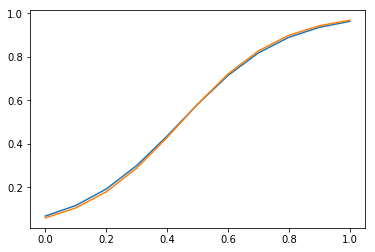

In [21]:
def a(w,x):
    return w[0] + w[1]*x

def sigmoid(a):
    return 1/(1+np.exp(-a))

def L(y_pred,y_obs):
    return -np.sum(y_obs*np.log(y_pred) + (1-y_obs)*(np.log(1-y_pred)))

def grad_L(y_pred,y_obs,x):
    return np.array([np.sum(y_pred - y_obs),np.sum((y_pred-y_obs)*x)])

w = np.array([0.0,0.0])
eta = 1e-3
not_converged = True
for i in range(10000):
    y_pred = sigmoid(a(w,x))
    w -= eta*grad_L(y_pred,y,x)
    #print(L(y_pred,y))
    # Compute objective function gradient
    # Update parameters w
    
y_pred_logistic = sigmoid(a_logistic)
print(L(y_pred,y),L(y_pred_logistic,y))

print(np.sum(y == (y_pred>0.5))/len(y))
print(np.sum(y == (y_pred_logistic>0.5))/len(y))

plt.plot(x,y_pred)
plt.plot(x,sigmoid(a_logistic))
plt.show()

# 3 Extension to multiple classes and multiple features
Logistic regression is very cool and useful, however it is limited to cases with only two classes (i.e. a binary classification problem).  We can generalize it, but we'll want to develop a bit of useful notation before we do

## 3a One hot encoding for class
Previously, we have been assuming that our classes are labeled as integers, i.e. 
$$
y \in \{0,1,2,\ldots,N\}
$$
where $N$ is the number of possible classes.  However, this turns out to be a little bit cumbersome because it requires special operations like the Iverson Bracket in order to correctly write the categorical distribution.  We can simplify this notation at the expense of using a little bit of extra space through the so-called *one-hot* encoding of class membership.  A one hot encoding simply transforms an integer class label (e.g. $y=2$) into a vector $\mathbf{y}$ with length $N$.  All of the entries in this vector are zero, except for the entry corresponding to the class label.  So for example
$$
y=2 \rightarrow \mathbf{y} = [0,0,1,0,\ldots,0].
$$
This obviously takes up a bit more space, but it allows us to write the categorical distribution in a very simple form:
$$
P(\mathbf{y}|\boldsymbol{\theta}) = \prod_{k=1}^N \theta_k^{y_k},
$$
where $\boldsymbol{\theta}$ is the vector of class probabilities.  

## 3b The softmax function
As we discovered before, the sigmoid function is derived directly from the two class expression of Bayes Theorem; perhaps we can find an analogous operation for the multi-class version of Bayes theorem:
$$
P(\mathbf{y}_k|\mathbf{x}) = \frac{P(\mathbf{x}|\mathbf{y}_k) P(\mathbf{y})}{\sum_{j=1}^N P(\mathbf{x}|\mathbf{y}_j) P(\mathbf{y}_j)},
$$
where $\mathbf{y}_j$ is the one-hot vector representing membership in class $k$.  

Unfortunately, we can't write this expression in terms of log-odds, because there is no such thing as odds in the multi-class context (odds being a ratio between two probabilities).  However, we can write this expression in terms of log-probabilities
$$
P(\mathbf{y}_k|\mathbf{x}) = S_k(a) = \frac{\exp a_k}{\sum_{j=1}^N \exp a_j}.
$$
The equation above is known as the **Softmax** function, with arguments
$$
a_k = \ln P(\mathbf{x}|\mathbf{y}_k) P(\mathbf{y}_k).
$$
Just like the sigmoid, it returns a value between 0 and 1 which can be interpreted as a probability, one for each class.  Note that $S(a)$ is a function from $\mathcal{R}^N \rightarrow \mathcal{R}^N$: it takes the log-probability of the likelihood times prior for each of the three classes, and returns the class membership for each of the three classes.  

There are a few nice properties of Softmax.  First, if we evaluate $S(a)$ for each class of interest, all the resulting values sum to one.  Second, in the event that there are only two classes, the softmax function can be interpreted as equivalent to the sigmoid under an appropriate rescaling.  

## 3c Using softmax for classification
How do we use the softmax function for classification?  The process again mirrors logistic regression.  We'll model $a$ as a linear combination of the input values.
$$
a = \boldsymbol{\phi}^T W,
$$
where $W$ is a matrix of parameters of size $(n+1) \times N$, where we'll assume that our vector of features $\boldsymbol{\phi}^T$ always includes a constant element, i.e.
$$
\boldsymbol{\phi}^T = [x_1,x_2,\ldots,x_n,1].
$$
Since we're multiplying a $1\times (n+1)$ vector with a $(n+1) \times N$ matrix, we'll get a $1\times N$ vector out.  Thus, $a$ is a row vector.  If we know the weight matrix $W$, then the process of classification is as simple as computing $a$, evaluating softmax, and finding the argmax of $S(a)$.    

## IC4B Implement the softmax function
Your first task is to write the function that computes softmax, and to ensure that it works correctly.  **Import the iris dataset, and split it into test and training sets.  Instantiate a random weight matrix $W$ and evaluate $a$ for some entry in the iris dataset (remember that there needs to be a one appended to the set of features!).  Create a function that evaluates softmax as a function of $a$.  Evaluate it for your chosen iris, and show that the resulting probabilities add up to unity.**

## 3d Learning the weights for softmax regression

The softmax function gives us the mechanism that we need to produce class membership probabilities, under the proviso that we also know an appropriate weight matrix $W$.  Regrettably, we do not: these are parameters which must be learned.  Fortunately, we can proceed in a way very similar to logistic regression, by specifying the objective function, taking its derivative with respect to the entries of the weight matrix, and then using gradient descent to find its minimum. 

Because we're going to be finding the minimum of a function with respect to a number of data points, it will be useful to define some arrays to hold the observed data.  First, let's define the *design matrix*
$$
\Phi = \begin{bmatrix} \boldsymbol{\phi^T_1} \\
                       \boldsymbol{\phi^T_2} \\
                       \vdots \\
                       \boldsymbol{\phi^T_m} \end{bmatrix} =     
                             \begin{bmatrix} x_{11} & x_{12} & \ldots & x_{1n} & 1 \\
                             x_{21} & x_{22} & \ldots & x_{2n} & 1 \\
                             \vdots & \vdots & \ddots & \vdots & \vdots \\
                             x_{m1} & x_{m2} & \ldots & x_{mn} & 1 \end{bmatrix} 
$$                             
and the *target matrix* with each one-hot encoded class label (this is a $m \times N$!)
$$
T = \begin{bmatrix} \hat{\mathbf{y}}_1 \\
                    \hat{\mathbf{y}}_2 \\
                           \vdots\\
                    \hat{\mathbf{y}}_m \end{bmatrix},
$$                    
and
$$
A = \Phi W = \begin{bmatrix} a_1 \\ a_2 \\ \vdots \\ a_m \end{bmatrix},
$$
which is $m\times N$.

Just as we used the log-likelihood of the Bernoulli distribution as the objective function for logistic regression, we can minimize the negative log-likelihood of the Categorical distribution as the objective function for softmax:
$$
\mathcal{L} = -\sum_{i=1}^m \sum_{k=1}^N T_{ik} \ln S_{k}(a_i),
$$
where $S_k(a_i)$ is the $k$-th output of the softmax function evaluated on training datum $i$.  Taking the derivative of softmax with respect to the weights isn't quite as straightforward as it was for logistic regression because of the vector-valued inputs and outputs, but we can break it down into parts.

Before we compute the full derivative of $\mathcal{L}$ with respect to the entries in $W$, We can start off by taking the derivative of $\mathcal{L}$ with respect to $a_j$.  Let's start off by ignoring the outer sum (over the data points).  Because the summation over the data points is linear, we can just sum up the individual contributions from each data point's misfit at the end.  We'll denote this elementwise cost as $\mathcal{L}'$.  The chain rule tells us that
$$
\frac{\partial \mathcal{L}'}{\partial a_j} = -\sum_{k=1}^N \frac{T_k}{S_k(a)} \frac{\partial S_k(a)}{\partial a_j},
$$
We can now make use of the nice fact that 
$$
\frac{\partial S_k(a_i)}{\partial a_j} = \begin{cases} S_k(1-S_j) & \text{if} \; k=j \\
                                                  - S_k S_j  & \text{if} \; k\neq j \end{cases} = S_k(\delta_{kj} - S_j).
$$                                                  
The cases make this unwieldy, but we can actually use it split up the sum over classes
$$
\frac{\partial \mathcal{L}'}{\partial a_j} = -\left[ T_j (1-S_j(a)) - \sum_{k\neq j} T_k S_j(a) \right].
$$
The softmax $S_j$ outside the sum turns out to just be the missing softmax inside the sum (because of the $j\neq k$ condition), so we have that
$$
\frac{\partial \mathcal{L}'}{\partial a_j} = -\left[ T_j - S_j(a)\sum_{k=1}^N T_k \right].
$$
However, recall that the entries over the classes in $T_k$ must sum to one, which means that
$$
\frac{\partial \mathcal{L}'}{\partial a_j} = -(T_j - S_j(a)).
$$

We're not quite there.  We have the derivative of $\mathcal{L}'$ with respect to the outputs of the linear functions $a_j$, but what we want is the derivative with respect to the entries in $W$.  However, this is just an application of the (multidimensional) chain rule: 
$$
\nabla_{W_j} \mathcal{L}' = \frac{\partial \mathcal{L}_i'}{\partial a_j}\nabla_{W_j}  a_j,
$$
where we're using $W_j$ to denote the $j$-th column in the weight matrix $W$.  We've already computed $\frac{\partial \mathcal{L}'}{\partial a_j}$.  Now we need
$$
\nabla_{W_j} a_j.
$$
But since 
$$
a_j = \boldsymbol{\phi}^T W_j,
$$
we simply have that 
$$
\nabla_{W_j} a_j = \boldsymbol{\phi}^T
$$
and that
$$
\nabla_{W_j} \mathcal{L}' = -\underbrace{\boldsymbol{\phi}}_{(n+1) \times 1} \underbrace{[T_j - S_j(a)]}_{1\times 1},
$$
which is an $(n+1)$ length column vector, perfect for adjust the $j$-th column of the weight matrix $W$.  We can eliminate the j-subscript and just take the derivative of $\mathcal{L}'$ with respect to the entire matrix $W$ with
$$
\nabla_{W} \mathcal{L}' = \underbrace{\boldsymbol{\phi}}_{(n+1) \times 1} \underbrace{[T - S(a)]}_{1\times N}.
$$
As expected, the derivative of a scalar with respect to a matrix is the size of the matrix itself.  Finally, we just need to take the sum over all the datapoints:
$$
\nabla_{W} \mathcal{L} = \sum_{i=1}^m \mathcal{L}' = -{\underbrace{\Phi^T}_{(n+1)\times{m}}} \underbrace{[T - S(A)]}_{m\times N},
$$

While this derivation is a little bit complex, once finished, it's easy to implement, and is very nice in that it relies upon matrix multiplication rather than any expensive and error-prone loops.  Let's apply this to the iris dataset.

In [108]:
from sklearn import datasets  # Import the sklearn datasets module
from sklearn.model_selection import train_test_split
import matplotlib as mpl      # Plotting tools
mpl.rcParams['figure.figsize'] = [18,15]
mpl.rcParams['font.size'] = 18
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(53)

#Load the dataset
iris = datasets.load_iris()
x = iris.data 
y = iris.target

x,x_test,y,y_test =  train_test_split(x,y)

m = x.shape[0]
n = x.shape[1]
N = 3

# Design matrix
Phi = np.hstack((x,np.ones((x.shape[0],1))))

# Function to convert categorical labels into one-hot matrix.
def convert_to_one_hot(y,n_classes):
    T = np.zeros((y.shape[0],n_classes))
    for t,yy in zip(T,y):
        t[yy]=1   
    return T
T = convert_to_one_hot(y,N)  

Now that we have $T$ and $\Phi$, we can implement a softmax that can accept a matrix.

In [109]:
def softmax(A):
    numerator = np.exp(A)
    denominator = numerator.sum(axis=1)
    return numerator/denominator[:,np.newaxis]    

To prepare for updating $W$ using gradient descent, we'll need functions that compute both the categorical cross-entropy and its gradient with respect to $W$.  To evaluate these functions, we'll need to instantiate a (usually random or null) weight matrix $W$.

In [110]:
W = np.random.randn(n+1,N)
A = Phi @ W

def L(T,S):
    return -np.sum(T*np.log(S))

def gradient(y_obs,y_pred,Phi):
    return - Phi.T @ (T - S)

S = softmax(Phi@W)
print("Categorical Cross Entropy:",L(T,S))
print("Gradient with respect to W:", gradient(T,S,Phi))

Categorical Cross Entropy: 673.1059285964478
Gradient with respect to W: [[-159.47375025 -200.07298942  359.54673967]
 [-119.54323605  -93.58147128  213.12470732]
 [ -24.11226765 -143.39184359  167.50411125]
 [   2.90373591  -44.39849203   41.49475612]
 [ -33.29560915  -33.99449528   67.29010443]]


Now, it's as simple as running gradient descent.

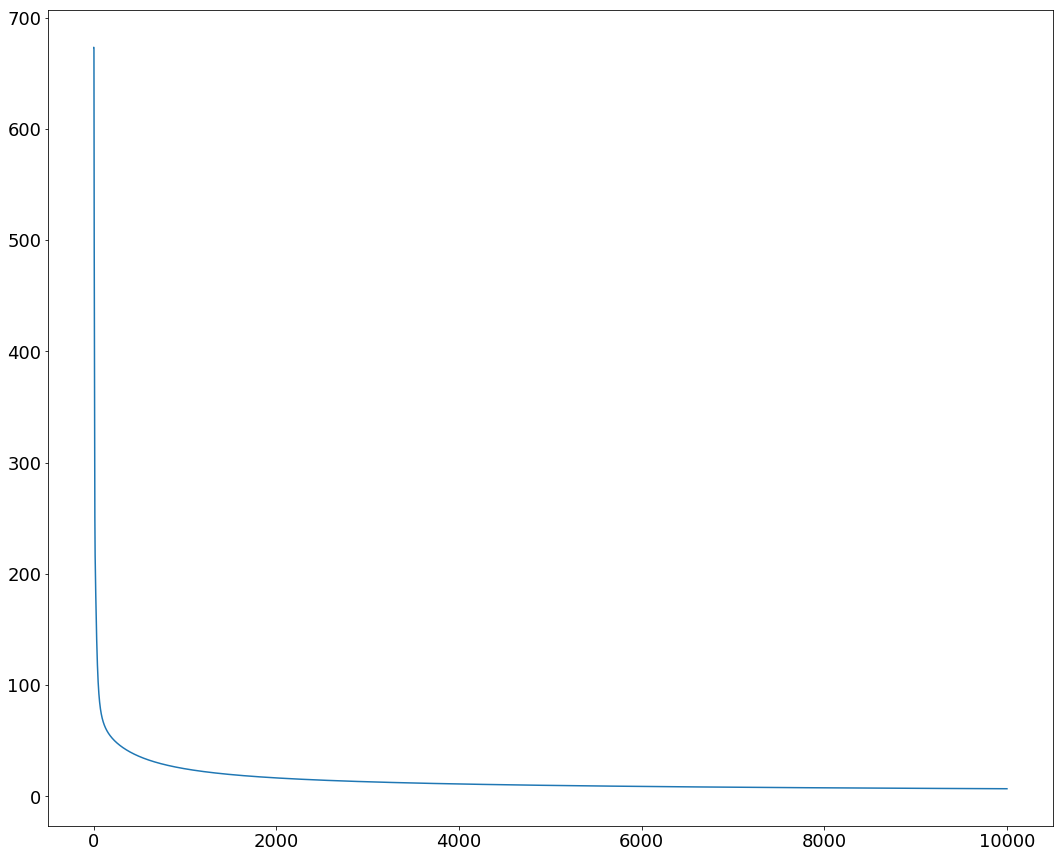

In [111]:
eta = 3e-4
L_record = []
for t in range(10000):
    L_record.append(L(T,S))
    S = softmax(Phi@W)
    g = gradient(T,S,Phi)
    W -= eta*g

plt.plot(L_record)
    

How did we do?  We have our class probabilities stored in $S$, so we can immediately compute our training set accuracy:

In [112]:
y_pred = np.argmax(S,axis=1)
print('Training set accuracy:',np.sum(y_pred == y)/len(y))

Training set accuracy: 0.9821428571428571


We get 97% accuracy at iris classification on the training set using this method.  How does this compare to naive Bayes, which we can view softmax regression as a variant of?  We'll need to fit a naive Bayes model.  We'll use a method built into scikit-learn to do this quickly.

In [113]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(x, y)
y_pred_nb = clf.predict(x)
print(np.sum(y_pred_nb == y)/len(y))

0.9553571428571429


On the training set, softmax regression outperforms naive Bayes by a few percentage points.  This is quite typical: while we lose a bit of transparency and control in the classification process by eliminating explicit probabilistic models of the features, we tend to gain explanatory power.  **However**, training set accuracy isn't really the most interesting metric: what we're really concerned about is test set accuracy.  How do the two models compare in that regard?

In [114]:
Phi_test = np.hstack((x_test,np.ones((x_test.shape[0],1))))
S_test = softmax(Phi_test@W)
y_pred_test = np.argmax(S_test,axis=1)
print('Test set accuracy (softmax):', sum(y_pred_test==y_test)/len(y_test))
y_pred_test_nb = clf.predict(x_test)
print('Test set accuracy (naive Bayes):', sum(y_pred_test_nb==y_test)/len(y_test))


Test set accuracy (softmax): 0.9473684210526315
Test set accuracy (naive Bayes): 0.9210526315789473


Similarly, softmax does a slightly better job.  Note that this isn't a very robust comparison, and if we change the random division of the data set into training and test sets, we can (and will) get different numbers.  However, it is generally accepted that softmax is a more expressive model that typically yields better predictive accuracy.

## 4 Metrics for assessing classification performance
As a final note, we've been using the very simple metric "accuracy" (the number of correct classifications divided by the total number of classifications) to assess model performance.  While this is a useful overall thing to look at, there are other ways to evaluate models.  One very simple way of doing this is with a confusion matrix, which gives us on the vertical axis the predicted class and on the horizontal axis the actual class:

In [121]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred_test,y_test)

array([[10,  0,  0],
       [ 0, 14,  0],
       [ 0,  2, 12]])

Not only does this tell us how many examples were misclassified, but also where the confusion occurred.  In this case, 2 data points that were actually virginicas (class 2) were classified as versicolors (class 3).  With this in mind, we can compute two additional metrics, called *precision* and *recall*.  Precision asks the question: Of all the data points classified as a given class, how many of those classifications were correct?  Recall asks the converse question: Of all the data examples that actually are of a given class, how many examples were classified as such.

## IC4C 
**Write a function that accepts a confusion matrix and outputs each class's precision and recall.